## Bayesian linear regression

Recall: the goal of regression is to estimate an unknown function from a set of (noisy) function values.
Let's assume we want to estimate some function $f: \mathbb{R}^D \rightarrow \mathbb{R}$ from data set $\mathcal{D} = \{(\mathbf{x}_1,y_1), \ldots, (\mathbf{x}_N,y_N)\}$, where $y = f(\mathbf{x}) + \epsilon$.

The first step in the estimation process is to define a model for $f$ and the noise term $\epsilon$. The simplest of models is the linear model, which assumes that $f$ is a linear function. If we assume white Gaussian noise, the linear model becomes:
$$
y = \boldsymbol{\beta}^T\mathbf{x} + \epsilon \\
\epsilon \sim \mathcal{N}(0, \sigma^2),
$$
where $\boldsymbol{\beta}$ is the vector containing the coefficients. Under this model, regression boils down to fitting $\boldsymbol{\beta}$ to $\mathcal{D}$. This can be done by maximum likelihood estimation, but here we will take a full Bayesian approach by defining a prior on $\boldsymbol{\beta}$ and then calculating the posterior distribution. This has two important advantages over maximum likelihood estimation:

1. The posterior distribution provides a measure of uncertainty about the coefficient vector, instead of just a point estimate.
2. The prior prevents over-fitting.


## Joint distribution and factor graph

The above model translates to the following joint distribution:
$$
p(y_{1:N}, \epsilon_{1:N}, \boldsymbol{\beta} | \mathbf{x}_{1:N}) = \underbrace{p(\boldsymbol{\beta})}_{\text{prior}} \prod_{i=1}^N  \underbrace{p(y_i|\boldsymbol{\beta}, \mathbf{x}_i, \epsilon_i)}_{\text{linear model}} \underbrace{p(\epsilon_i)}_{\text{noise model}}
$$

It is common to put a multivariate Gaussian prior with zero mean on $\boldsymbol{\beta}$: 
$$
p(\boldsymbol{\beta}) = \mathcal{N}(\mathbf{0}, \Sigma).
$$

To facilitate inference of $\boldsymbol{\beta}$, we will draw the factor graph of this distribution. This is useful because we can calculate the posterior distribution $p(\boldsymbol{\beta}|\mathcal{D})$ by sum-product message passing.

**TODO: draw factor graph and message passing schedule?**

### Build factor graph

In [1]:
using ForneyLab, PyPlot
include("script/innerproduct_node.jl");

In [6]:
# Parameters
Σ = 1e5 * eye(3) # Covariance matrix of prior on β
σ2 = 2.0         # Noise variance

fg = FactorGraph()
beta_prior = TerminalNode(MvGaussian(m=zeros(3), V=Σ), id=:beta_prior)
beta_terminator = TerminalNode(vague(MvGaussian{3}), id=:beta_terminator)
equ = EqualityNode()
x = TerminalNode(MvDelta(zeros(3)), id=:x)
dot = DotProductNode()
noise = GaussianNode(V=σ2, id=:noise)
y = TerminalNode(Delta(0.0), id=:y)

Edge(beta_prior, equ)
beta_edge = Edge(equ, beta_terminator)
Edge(equ, dot.i[:β])
Edge(x, dot.i[:in])
Edge(dot.i[:out], noise.i[:mean])
Edge(noise.i[:out], y)
Wrap(beta_terminator, beta_prior)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10199238352557313334 -->
 10199238352557313334 
 
 beta_terminator 
 
<!-- 10707969044945225831 -->
 10707969044945225831 
 
 beta_prior 
 
<!-- 10199238352557313334->10707969044945225831 -->
 10199238352557313334->10707969044945225831 
 
 
 
<!-- 2797394399557195772 -->
 2797394399557195772 
 
 x 
 
<!-- 10568101390476952895 -->
 10568101390476952895 
 
 DotProductNode 
 dotproduct1 
 
<!-- 2797394399557195772->10568101390476952895 -->
 2797394399557195772->10568101390476952895 
 
 
 1 in 
 1 out 
 
<!-- 7497173798592226036 -->
 7497173798592226036 
 
 = 
 equality1 
 
<!-- 10707969044945225831->7497173798592226036 -->
 10707969044945225831->7497173798592226036 
 
 
 1 1 
 1 out 
 
<!-- 17302847676976567027 -->
 17302847676976567027 
 
 N 
 noise 
 
<!-- 984981380917631241 -->
 984981380917631241 
 
 y 
 
<!-- 17302847676976567027->984981380917631241 -->
 17302847676976567027->984981380917631241 
 
 
 1 out 
 2 out 
 
<!-- 7497173798592226036->10199238352557313334 -->
 7497173798592226036->10199238352557313334 
 
 
 1 out 
 2 2 
 
<!-- 7497173798592226036->10568101390476952895 -->
 7497173798592226036->10568101390476952895 
 
 
 2 β 
 3 3 
 
<!-- 10568101390476952895->17302847676976567027 -->
 10568101390476952895->17302847676976567027 
 
 
 1 mean 
 3 out

### Generate data set

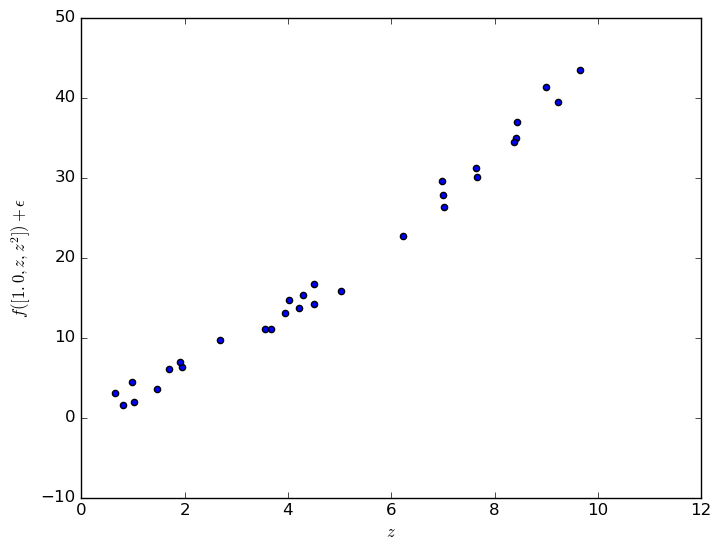

In [7]:
β = [1.0; 2.0; 0.25]
N = 30
z = 10.0*rand(N)
x_train = [[1.0; z; z^2] for z in z] # Feature vector x = [1.0; z; z^2]
f(x) = (β'*x)[1]
y_train = map(f, x_train) + sqrt(σ2)*randn(N) # y[i] = β' * x[i] + ϵ
scatter(z, y_train); xlabel(L"z"); ylabel(L"f([1.0, z, z^2]) + \epsilon");

### Perform sum-product message passing

In [9]:
algo = SumProduct(beta_edge)
attachReadBuffer(x, x_train)
attachReadBuffer(y, y_train)
run(algo)
beta_posterior_dist = calculateMarginal(beta_edge)
println("Posterior mean of β: $(mean(beta_posterior_dist))")
println("Posterior covariance of β: $(cov(beta_posterior_dist))")

Posterior mean of β: [0.968858,2.13386,0.235352]
Posterior covariance of β: [0.709847 -0.3015 0.026012; -0.3015 0.161287 -0.0152499; 0.026012 -0.0152499 0.00152012]


### Plot result (mean of posterior)

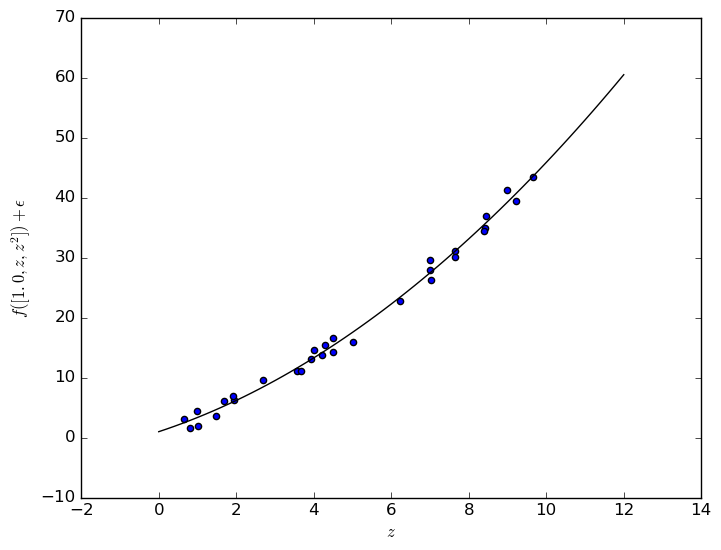

In [13]:
scatter(z, y_train); xlabel(L"z"); ylabel(L"f([1.0, z, z^2]) + \epsilon");
f_est(x) = (mean(beta_posterior_dist)'*x)[1]
z_test = collect(0:0.2:12)
x_test = [[1.0; z; z^2] for z in z_test]
plot(z_test, map(f_est, x_test), "k-");